# Northwind Data Analysis

## Description:
In this project, I aim to perform some exploratory data analysis as well as sample business questions that could be answered with the data

## Pre-Reqs
You will need to perform the following: <br>
<ul>
    <li>Install Microsoft SQL Server Management Studio: <a href="https://learn.microsoft.com/en-us/sql/ssms/download-sql-server-management-studio-ssms?view=sql-server-ver16">https://learn.microsoft.com/en-us/sql/ssms/download-sql-server-management-studio-ssms?view=sql-server-ver16</a> </li>
    <li>Create the Northwind Database: <a href="https://github.com/Microsoft/sql-server-samples/tree/master/samples/databases/northwind-pubs">https://github.com/Microsoft/sql-server-samples/tree/master/samples/databases/northwind-pubs"</a></li>
</ul>

In [1]:
import os
import sys
sys.path.append(os.path.realpath('..'))
from sqlalchemy import create_engine, MetaData
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from pandasql import sqldf
from sqlalchemy_schemadisplay import create_schema_graph
from configuration.config import DB_HOST #you will need to create this. It is not recommended to store any server credentials in a Github repo

In [2]:
%matplotlib inline

In [3]:
northwind_engine = create_engine(f"mssql+pymssql://{DB_HOST}/Northwind")

## ERD
I like to create the ERD to display relationships amongst the tables

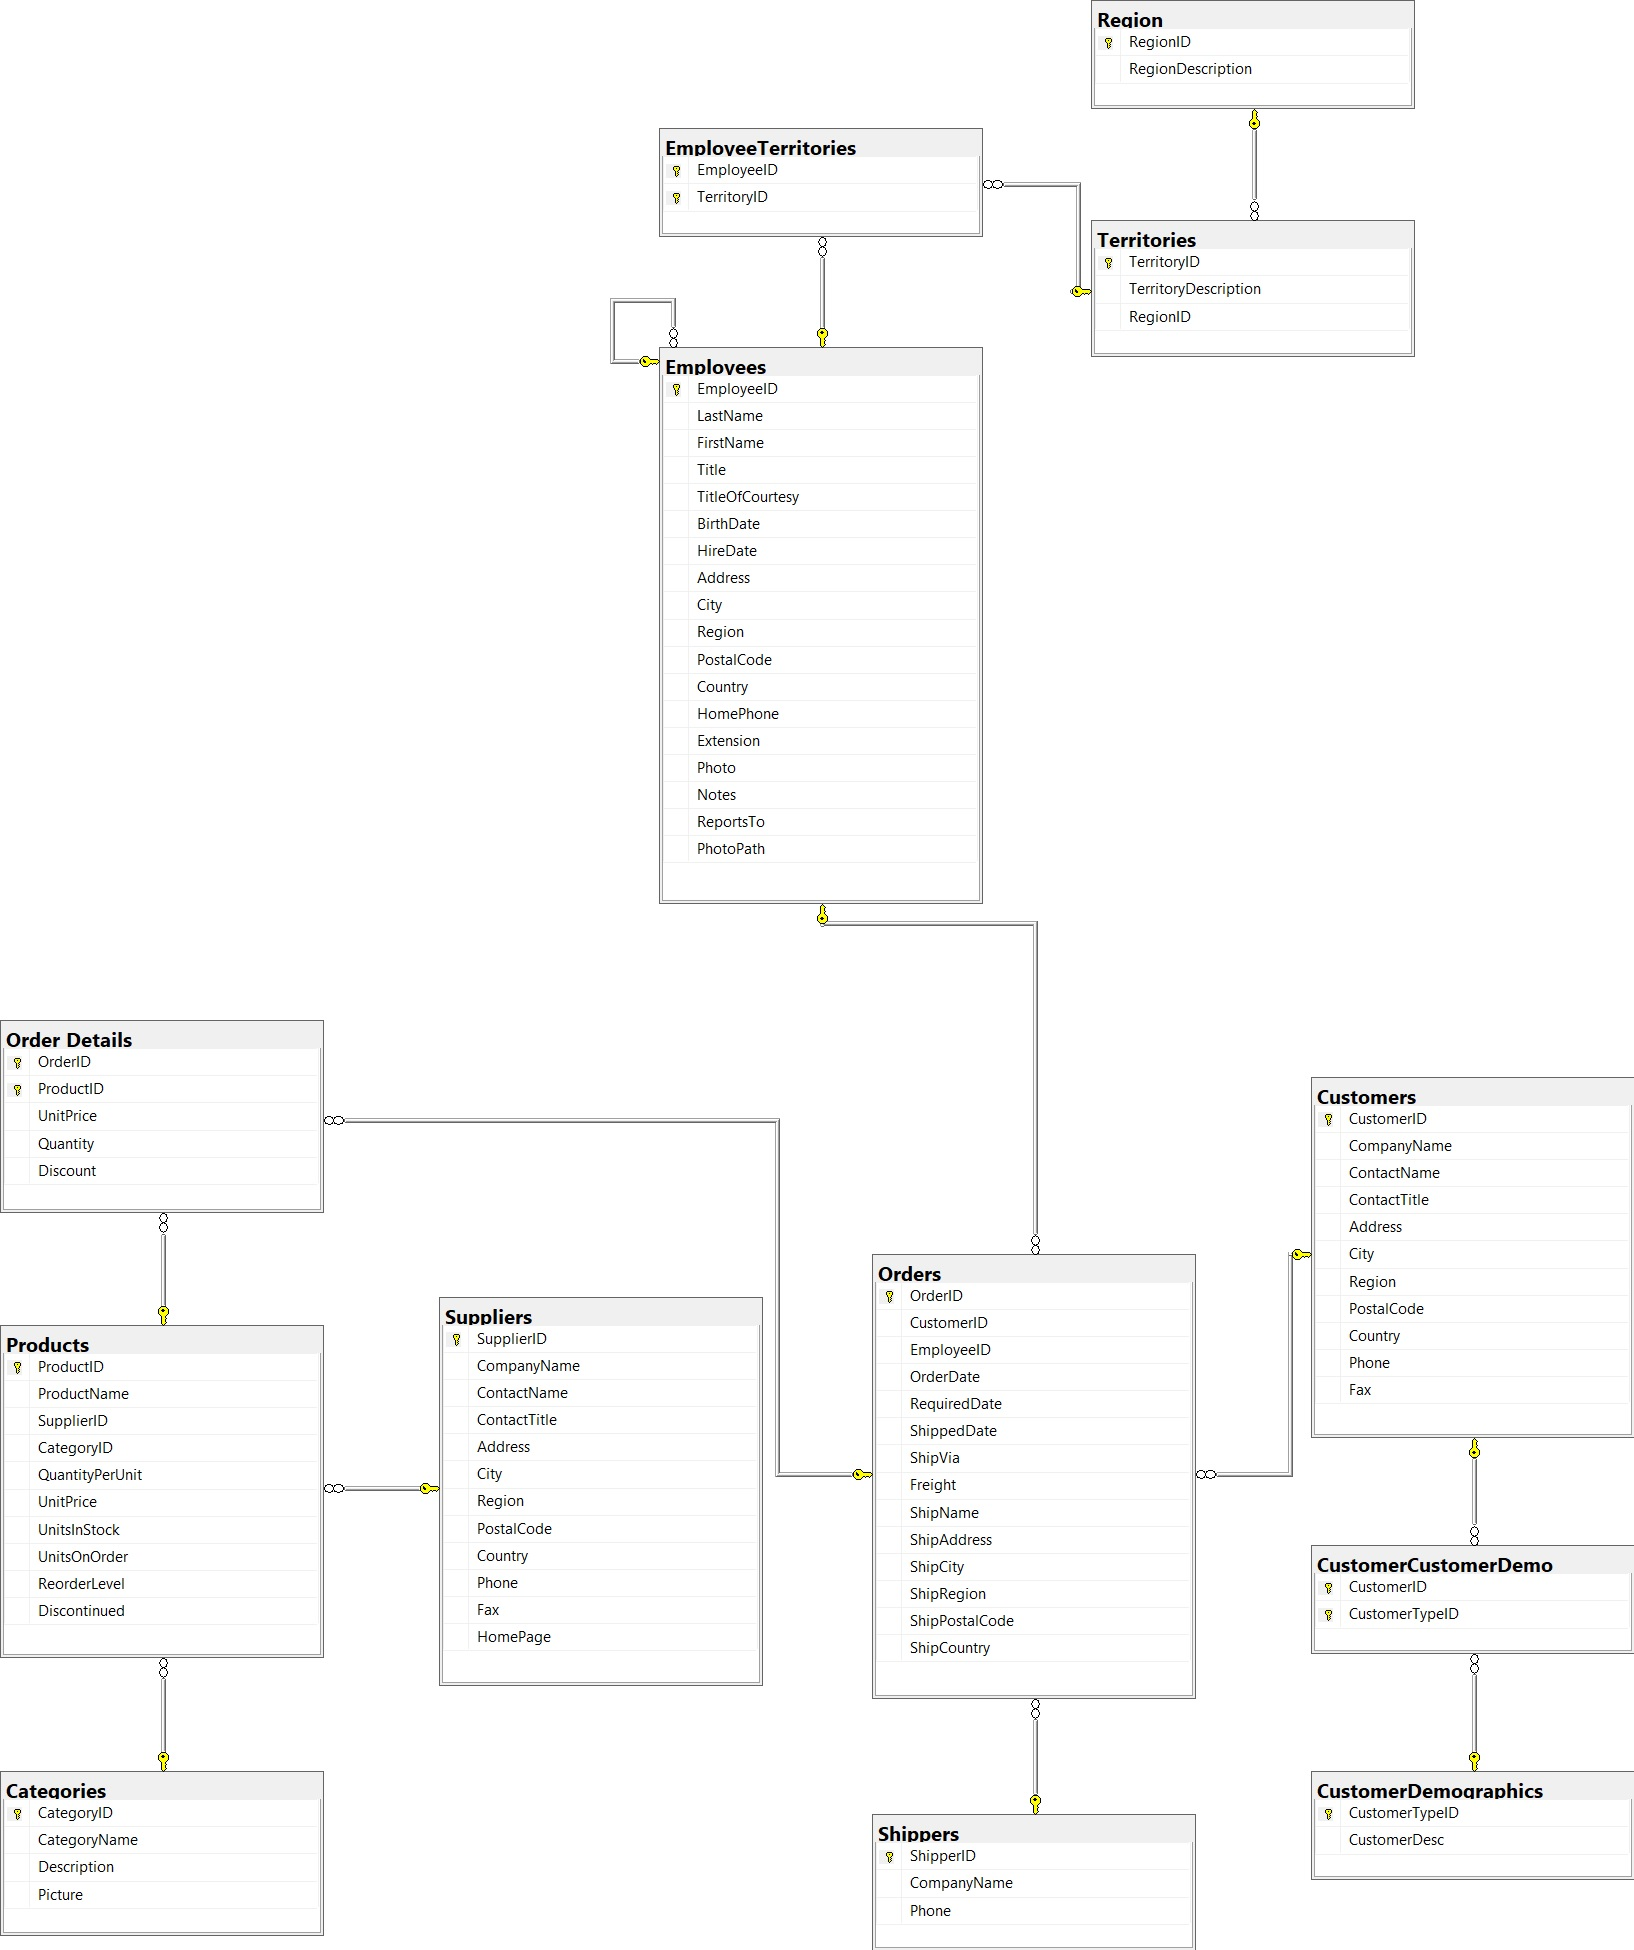

In [4]:
Image(filename= 'northwind_erd.jpg')

## Import all of this data

In [5]:
customers = pd.read_sql("SELECT * FROM Customers", con = northwind_engine)
orders = pd.read_sql("SELECT * FROM Orders", con = northwind_engine, parse_dates = ['OrderDate', 'RequiredDate', 'ShippedDate'])
order_details = pd.read_sql("SELECT * FROM [Order Details]", con = northwind_engine)
products = pd.read_sql("SELECT * FROM Products", con = northwind_engine)
categories= pd.read_sql("SELECT * FROM Categories", con = northwind_engine)
suppliers = pd.read_sql("SELECT * FROM Suppliers", con = northwind_engine)
shippers = pd.read_sql("SELECT * FROM Shippers", con = northwind_engine)
employees = pd.read_sql("SELECT * FROM Employees", con = northwind_engine)

## Create a Date Dimension

In [67]:
dates_dim = pd.DataFrame()
dates_dim['Date'] = pd.date_range(start='1996-01-01', end = '1998-12-31', freq = 'D')
dates_dim['Month'] = dates_dim['Date'].dt.month
dates_dim['MonthName'] = dates_dim['Date'].dt.month_name()
dates_dim['Day'] = dates_dim['Date'].dt.day
dates_dim['DayName'] = dates_dim['Date'].dt.day_name()
dates_dim['Year'] = dates_dim['Date'].dt.year

In [68]:
dates_dim

,Date,Month,MonthName,Day,DayName,Year
0,1996-01-01,1,January,1,Monday,1996
1,1996-01-02,1,January,2,Tuesday,1996
2,1996-01-03,1,January,3,Wednesday,1996
3,1996-01-04,1,January,4,Thursday,1996
4,1996-01-05,1,January,5,Friday,1996
...,...,...,...,...,...,...
1091,1998-12-27,12,December,27,Sunday,1998
1092,1998-12-28,12,December,28,Monday,1998
1093,1998-12-29,12,December,29,Tuesday,1998
1094,1998-12-30,12,December,30,Wednesday,1998


# Data Analysis

## Look at Orders By Country

In [27]:
sqldf("""
SELECT 
    ShipCountry,
    COUNT(OrderID) as number_orders
FROM orders
GROUP BY ShipCountry
ORDER BY
    number_orders DESC
"""
     )

,ShipCountry,number_orders
0,USA,122
1,Germany,122
2,Brazil,83
3,France,77
4,UK,56
5,Venezuela,46
6,Austria,40
7,Sweden,37
8,Canada,30
9,Mexico,28


<Axes: title={'center': 'Number of Orders by Country'}, xlabel='Country', ylabel='Number of Orders'>

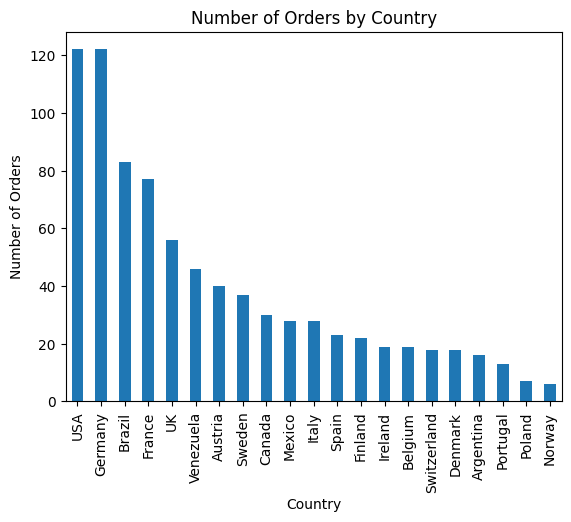

In [31]:
sqldf("""
SELECT 
    ShipCountry,
    COUNT(OrderID) as number_orders
FROM orders
GROUP BY ShipCountry
ORDER BY
    number_orders DESC
"""
     ).plot(kind = 'bar', x = 'ShipCountry', xlabel = 'Country', y='number_orders', ylabel = 'Number of Orders', legend = False, title = 'Number of Orders by Country')

Looks like there is a tie between the USA and Germany for number of orders

# Orders over Time
Taking inspiration from the Orders by Country, we want to see orders for Northwind over time

In [94]:
sqldf(
    """
    SELECT
        OrderID,
        OrderDate,
        strftime('%Y', OrderDate) as OrderYear, -- sqldf is based on sqlite. therefore we cannot use the DATEPART function in T-SQL
        strftime('%m', OrderDate) as OrderMonth,
        strftime('%d', OrderDate) as OrderDay
    FROM
        orders
    """
)

,OrderID,OrderDate,OrderYear,OrderMonth,OrderDay
0,10248,1996-07-04 00:00:00.000000,1996,07,04
1,10249,1996-07-05 00:00:00.000000,1996,07,05
2,10250,1996-07-08 00:00:00.000000,1996,07,08
3,10251,1996-07-08 00:00:00.000000,1996,07,08
4,10252,1996-07-09 00:00:00.000000,1996,07,09
...,...,...,...,...,...
825,11073,1998-05-05 00:00:00.000000,1998,05,05
826,11074,1998-05-06 00:00:00.000000,1998,05,06
827,11075,1998-05-06 00:00:00.000000,1998,05,06
828,11076,1998-05-06 00:00:00.000000,1998,05,06


<Axes: title={'center': 'Orders by Year'}, xlabel='Year', ylabel='Number of Orders'>

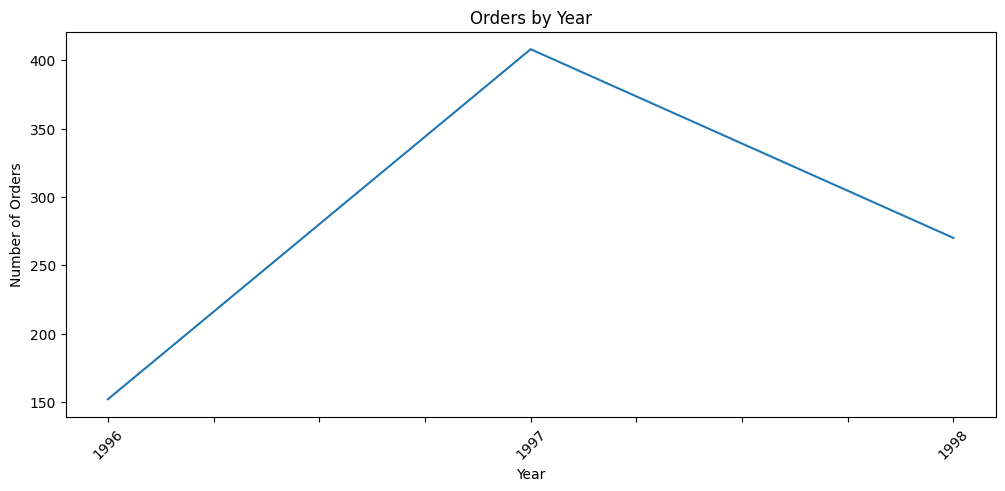

In [96]:
sqldf(
    """
    SELECT
        strftime('%Y', OrderDate) as OrderYear,
        COUNT(OrderID) as number_orders
    FROM
        orders
    GROUP BY
       strftime('%Y', OrderDate) 
    """
).plot(kind = 'line', x= 'OrderYear', xlabel='Year', y = 'number_orders', ylabel = 'Number of Orders', rot = 45, figsize = ((12,5)),
      title = 'Orders by Year', legend = False)

<Axes: title={'center': 'Orders by Year By Month'}, xlabel='Year-Month', ylabel='Number of Orders'>

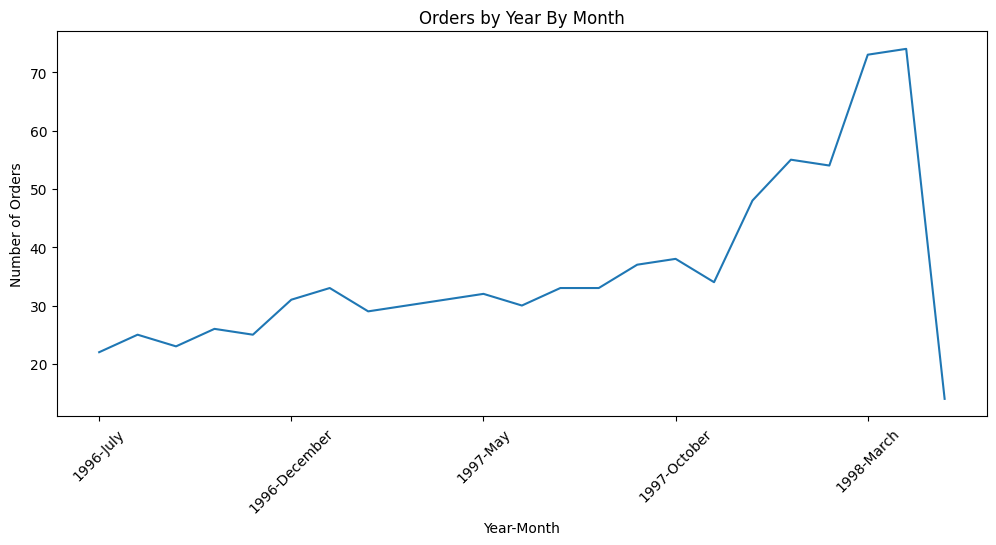

In [93]:
sqldf(
    """
    SELECT
        a.OrderYear || '-' || d.MonthName as year_month,
        a.number_orders
    FROM(
    SELECT
        strftime('%Y', OrderDate) as OrderYear,
        strftime('%m', OrderDate) as OrderMonth,
        COUNT(OrderID) as number_orders
    FROM
        orders
    GROUP BY
       strftime('%Y', OrderDate),
       strftime('%m', OrderDate)
    ) a
    INNER JOIN (
        SELECT DISTINCT
            Year,
            Month,
            MonthName
        FROM dates_dim ) d
        ON a.OrderYear = d.Year
        AND a.OrderMonth = d.Month
    """
).plot(kind = 'line', x= 'year_month', xlabel='Year-Month', y = 'number_orders', ylabel = 'Number of Orders', rot = 45, figsize = ((12,5)),
      title = 'Orders by Year By Month', legend = False)

# Products Overview

## Products by category sold

In [97]:
sqldf("""
SELECT
    c.CategoryName,
    COUNT(od.ProductID) as items_sold
FROM
    order_details od
INNER JOIN products p
ON p.ProductID = od.ProductID
INNER JOIN categories c
ON c.CategoryID = p.CategoryID
GROUP BY
    c.CategoryName
"""
                                  )

,CategoryName,items_sold
0,Beverages,404
1,Condiments,216
2,Confections,334
3,Dairy Products,366
4,Grains/Cereals,196
5,Meat/Poultry,173
6,Produce,136
7,Seafood,330
